# "Next Generation Reservoir Computing"

Daniel J. Gauthier, Erik Bollt, Aaron Grifﬁth & Wendson A. S. Barbosa


*Nature Communications*, vol. 12, no. 1, p. 5564, Sep. 2021, doi: 10.1038/s41467-021-25801-2.


In [90]:
import numpy as np
import matplotlib.pyplot as plt
from dysts.flows import DoublePendulum


l1, l2 = 1.0, 1.0  # Lengths of pendulum arms
dt = 0.01
n_timesteps = 1500  # Significantly increase timesteps to observe prolonged chaos and flips
print(f"Number of timesteps: {n_timesteps}")


model = DoublePendulum()

model.ic = np.array([np.pi / 2, 0.0, np.pi / 2, 5.0])

X = model.make_trajectory(n_timesteps)

print(X.shape)

Number of timesteps: 1500
(1500, 4)


/home/julien2429/anaconda3/envs/py311/lib/python3.11/site-packages/dysts/base.py:353: UserWarning: This system has at least one unbounded variable, which has been mapped to a bounded domain. Pass argument postprocess=False in order to generate trajectories from the raw system.
  warnings.warn(


In [3]:
import matplotlib.pyplot as plt
import numpy as np

from reservoirpy.datasets import lorenz, doublescroll
from reservoirpy.observables import nrmse
from reservoirpy.nodes import Ridge, NVAR

%matplotlib inline

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ------------------------
# Parameters
# ------------------------

# time step duration (in time unit)
dt = 0.025
# training time (in time unit)
train_time  = 100.
# testing time (idem)
test_time   = 210.
# warmup time (idem): should always be > k * s
warm_time   = 30.

# discretization
train_steps = round(train_time / dt)
test_steps  = round(test_time  / dt)
warm_steps  = round(warm_time  / dt)

total_time = train_time + test_time + warm_time


m1, m2 = 1.0, 1.0  # Masses of pendulum bobs (kg)
l1, l2 = 1.0, 1.0  # Lengths of pendulum arms (m)
g = 9.81         # Acceleration due to gravity (m/s^2)


n_timesteps = train_steps + test_steps + warm_steps



theta1_0 = np.pi/2    # 90 degrees
o1_0 = 0.0            # start from rest
theta2_0 = np.pi/2    # 90 degrees  
o2_0 = 0.0            # start from rest

# Simulate
time, theta1, theta2, o1, o2 = simulate_double_pendulum(
    theta1_0, o1_0, theta2_0, o2_0, time_end=total_time, num_points=n_timesteps
)

# X = np.stack([theta1, theta2, o1, o2 ], axis=1)  
# print(f"Shape of X: {X.shape}")

# From the array [Z1, Z1_dot, Z2, Z2_dot], find collect dataset  [x1, x2, y1, y2 ,v_x1, v_y1,v_x2, and v_vy2]

def angles_to_cartesian(theta1, theta2, o1, o2, l1=1.0, l2=1.0):
    """
    Convert double pendulum angles and angular velocities to Cartesian positions and velocities.

    Returns:
        x1, y1, x2, y2, vx1, vy1, vx2, vy2 (all arrays)
    """
    # Positions
    x1 = l1 * np.sin(theta1)
    y1 = -l1 * np.cos(theta1)
    x2 = x1 + l2 * np.sin(theta2)
    y2 = y1 - l2 * np.cos(theta2)

    # Velocities
    vx1 = np.diff(x1)
    vy1 = np.diff(y1)
    vx2 = np.diff(x2)
    vy2 = np.diff(y2)

    return x1, y1, x2, y2, vx1, vy1, vx2, vy2

# Example usage:
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = angles_to_cartesian(theta1, theta2, o1, o2, l1=l1, l2=l2)

vx1 = np.concatenate(([0], vx1))  # Add initial velocity
vy1 = np.concatenate(([0], vy1))  # Add initial velocity
vx2 = np.concatenate(([0], vx2))  # Add initial velocity
vy2 = np.concatenate(([0], vy2))  # Add initial velocity

print(x1.size, y1.size, x2.size, y2.size, vx1.size, vy1.size, vx2.size, vy2.size)



X = np.stack([ x1, y1, x2, y2, vx1, vy1, vx2, vy2], axis=1)

13600 13600 13600 13600 13600 13600 13600 13600


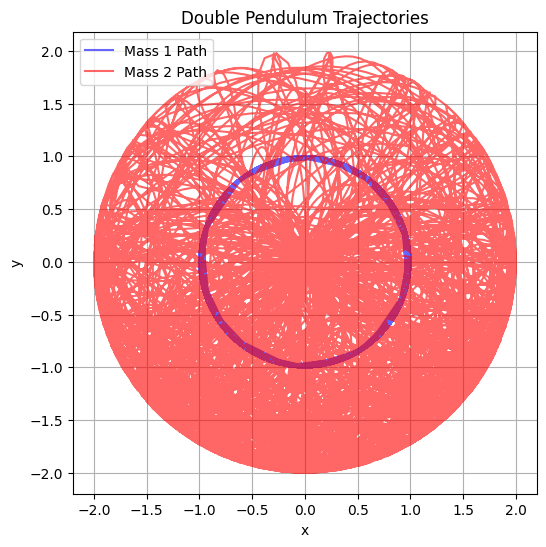

In [79]:


# ------------------------
# Convert to Cartesian: (x1, y1), (x2, y2)
def plot_data(x1, y1, x2, y2):


    cartesian_traj = np.stack([x1, y1, x2, y2], axis=1)  # shape: (n_timesteps, 4)

    # ------------------------
    # Plot the trajectory
    # ------------------------
    plt.figure(figsize=(8, 6))
    plt.plot(x1, y1, label='Mass 1 Path', color='blue', alpha=0.6)
    plt.plot(x2, y2, label='Mass 2 Path', color='red', alpha=0.6)
    plt.title("Double Pendulum Trajectories")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.gca().set_aspect('equal')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data(X[:,0], X[:,1], X[:,2], X[:,3])


In [80]:
from reservoirpy.nodes import Ridge, NVAR
nvar = NVAR(delay=1, order=2, strides=1) # 6 is good for order
readout = Ridge(8, ridge=2.5e-6, input_bias=False)

model = nvar >> readout

In [81]:
Xi  = X[:train_steps+warm_steps-1]
dXi = X[1:train_steps+warm_steps] - X[:train_steps+warm_steps-1]

print(f"Xi shape: {Xi.shape}, dXi shape: {dXi.shape}")

model = model.fit(Xi, dXi, warmup=warm_steps)

nvar.run(X[warm_steps+train_steps-2:warm_steps+train_steps])
u = X[warm_steps+train_steps]
res = np.zeros((test_steps, readout.output_dim))
for i in range(test_steps):
    u = u + model(u)
    res[i, :] = u

Xi shape: (5199, 8), dXi shape: (5199, 8)


Running Model-18: 5199it [00:01, 4610.67it/s]<?, ?it/s]
Running Model-18: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


Fitting node Ridge-18...


Running NVAR-18: 100%|██████████| 2/2 [00:00<00:00, 3430.92it/s]


(8400, 8)
(8400, 8)


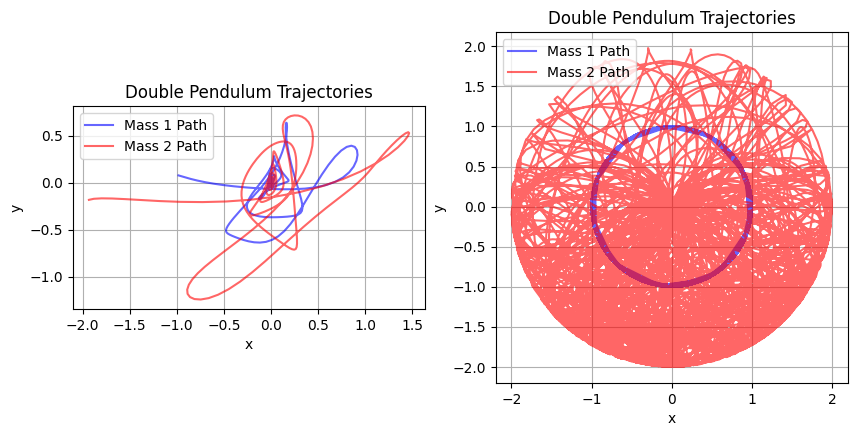

In [82]:
N = test_steps
Y = X[warm_steps+train_steps:]

fig = plt.figure(figsize=(10, 10))
ax  = fig.add_subplot(121)
ax.set_title("Generated pendulum")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.grid(False)

# Generated (from res)
x1_res, y1_res, x2_res, y2_res = res[:, 0], res[:, 1], res[:, 2], res[:, 3]
ax.plot(x1_res, y1_res, label='Mass 1 Path', color='blue', alpha=0.6)
ax.plot(x2_res, y2_res, label='Mass 2 Path', color='red', alpha=0.6)
ax.set_title("Double Pendulum Trajectories")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect('equal')
ax.legend()
ax.grid(True)

ax2 = fig.add_subplot(122)
ax2.set_title("Real pendulum")
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")

# Real (from Y)
x1_true, y1_true, x2_true, y2_true = Y[:, 0], Y[:, 1], Y[:, 2], Y[:, 3]
ax2.plot(x1_true, y1_true, label='Mass 1 Path', color='blue', alpha=0.6)
ax2.plot(x2_true, y2_true, label='Mass 2 Path', color='red', alpha=0.6)
ax2.set_title("Double Pendulum Trajectories")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_aspect('equal')
ax2.legend()
ax2.grid(True)

print(res.shape)
print(Y.shape)


In [86]:
%matplotlib widget
import matplotlib.pyplot as plt

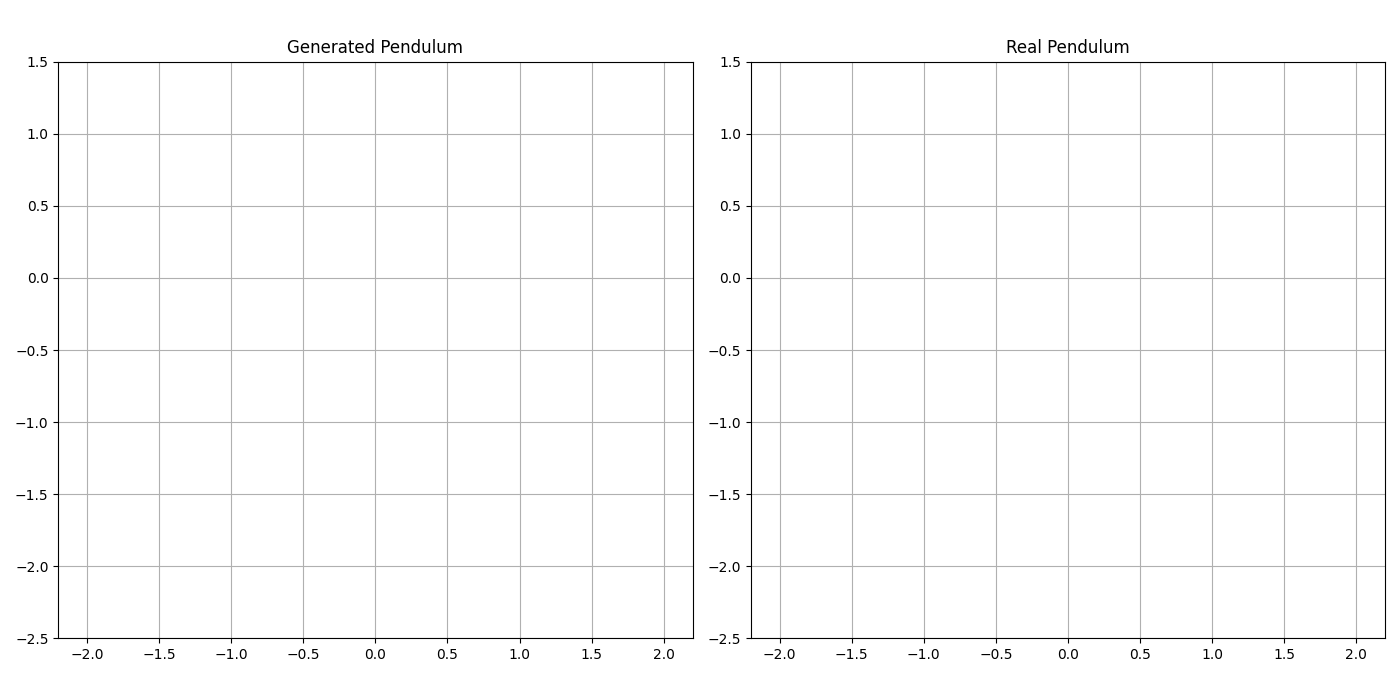

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# --- Pendulum lengths ---
l1, l2 = 1.0, 1.0

# --- Trajectory Data (already computed) ---
# X = full trajectory
# res = generated
# Y = ground truth
# test_steps, train_steps, warm_steps already defined

N = test_steps
Y = X[warm_steps + train_steps:]

# --- Helper: Convert angles to positions ---
def get_positions(data):

    x1 = data[:, 0]
    y1 = data[:, 1]
    x2 = data[:, 2]
    y2 = data[:, 3]
    return x1, y1, x2, y2

# --- Get both trajectories in Cartesian coordinates ---
x1_res, y1_res, x2_res, y2_res = get_positions(res)
x1_true, y1_true, x2_true, y2_true = get_positions(Y)

# --- Set up figure and axes ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

for ax in (ax1, ax2):
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-2.5, 1.5)
    ax.set_aspect('equal')
    ax.grid(True)

ax1.set_title("Generated Pendulum")
ax2.set_title("Real Pendulum")

# --- Initialize lines ---
gen_line1, = ax1.plot([], [], 'o-', lw=2, color='blue')
gen_line2, = ax1.plot([], [], 'o-', lw=2, color='red')

true_line1, = ax2.plot([], [], 'o-', lw=2, color='blue')
true_line2, = ax2.plot([], [], 'o-', lw=2, color='red')

# --- Initialization function ---
def init():
    gen_line1.set_data([], [])
    gen_line2.set_data([], [])
    true_line1.set_data([], [])
    true_line2.set_data([], [])
    return gen_line1, gen_line2, true_line1, true_line2

# --- Update function for animation ---
def update(frame):
    # Generated
    gen_line1.set_data([0, x1_res[frame]], [0, y1_res[frame]])
    gen_line2.set_data([x1_res[frame], x2_res[frame]], [y1_res[frame], y2_res[frame]])

    # Real
    true_line1.set_data([0, x1_true[frame]], [0, y1_true[frame]])
    true_line2.set_data([x1_true[frame], x2_true[frame]], [y1_true[frame], y2_true[frame]])

    return gen_line1, gen_line2, true_line1, true_line2

# --- Create animation ---
ani = FuncAnimation(fig, update, frames=N, init_func=init, blit=True, interval=20)

plt.tight_layout()
plt.show()
